In [3]:

from pycaret.regression import *
import matplotlib.pyplot as plt


pycaret regression : feature를 날짜로하여 수행 (datefeatures)

#https://pycaret.gitbook.io/docs/learn-pycaret/official-blog/time-series-101-for-beginners

In [4]:
import pandas as pd
data=pd.read_excel('/home/ykkim/Train_data/무림페이퍼_15분사용전력_210401-220630.xlsx')  
data=data.drop(['등록시각'],axis=1)

data['기준시각']=pd.to_datetime(data['기준시각'])
data.info()
len(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42766 entries, 0 to 42765
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   기준시각         42766 non-null  datetime64[ns]
 1   직전 15분 사용전력  42766 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 668.3 KB


42766

In [5]:
#이상치 제거
# 5100 이하값들은 이전 값들로 대체
import numpy as np
data.loc[(data['직전 15분 사용전력'] <= 5100),'직전 15분 사용전력']= np.nan
data.isna().sum()
data=data.fillna(method='ffill')
data.isna().sum()

기준시각           0
직전 15분 사용전력    0
dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


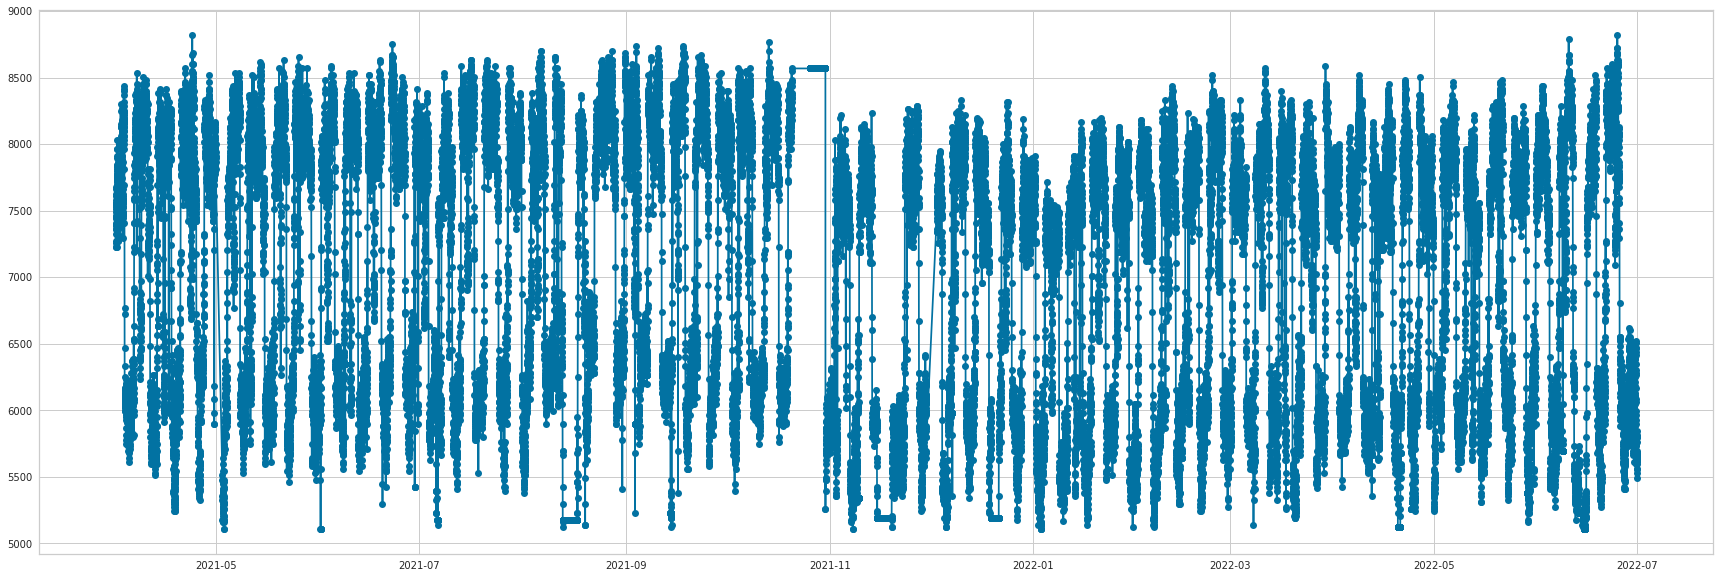

In [6]:
#plot
plt.figure(figsize=(30,10))
kws = dict(marker='o')
plt.plot(data['기준시각'],data['직전 15분 사용전력'], **kws)   
plt.legend()
plt.show()

In [7]:
#2. datetime을 feature(mon,day,hour,min,weekday)화  + lag
def date2features(data):
    data['year']=data['기준시각'].dt.year
    data['mon']=data['기준시각'].dt.month
    data['day']=data['기준시각'].dt.day
    data['hour']=data['기준시각'].dt.hour
    data['min']=data['기준시각'].dt.minute
    data['weekday']=data['기준시각'].dt.weekday
    data=data.drop(['기준시각'], axis=1)

    # data['Series']=data.index
    return data

In [8]:
#train_test split (Time Series)
def train_test_split(data,Time_name,train_cut_date,val_cut_date,end_time,want_val): # (data : dataframe , Time_name : 'dataframe 내 Time 변수명',want_val : validation set을 원할 경우'Y')

    data[Time_name]=pd.to_datetime(data[Time_name])
    df_train = data[data[Time_name] < train_cut_date ]
    df_test = data[(data[Time_name] >= val_cut_date) & (data[Time_name] <= end_time )] 
    print('train_df=',min(df_train[Time_name]),'~',max(df_train[Time_name]),',',len(df_train))
    print('test_df=',min(df_test[Time_name]),'~',max(df_test[Time_name]),',',len(df_test))

    if want_val=="Y":
        df_val= data[(data[Time_name] >= train_cut_date ) & (data[Time_name] < val_cut_date )]
        print('val_df=',min(df_val[Time_name]),'~',max(df_val[Time_name]),',',len(df_val))
        return (df_train,df_val,df_test) 

    return (df_train,df_test)  

#date to features

In [9]:
#train_test split
df_train,df_val,df_test=train_test_split(data,Time_name='기준시각',train_cut_date='2022-05-30',val_cut_date='2022-06-30',end_time='2022-06-30 23:45:00',want_val='Y')

train_df= 2021-04-01 00:00:00 ~ 2022-05-29 23:45:00 , 39694
test_df= 2022-06-30 00:00:00 ~ 2022-06-30 23:45:00 , 96
val_df= 2022-05-30 00:00:00 ~ 2022-06-29 23:45:00 , 2976


In [10]:
df_train_t=date2features(df_train)
df_val_t=date2features(df_val)
df_train_t

,직전 15분 사용전력,year,mon,day,hour,min,weekday
0,7224.0,2021,4,1,0,0,3
1,7274.4,2021,4,1,0,15,3
2,7442.4,2021,4,1,0,30,3
3,7392.0,2021,4,1,0,45,3
4,7576.8,2021,4,1,1,0,3
...,...,...,...,...,...,...,...
39689,5880.0,2022,5,29,22,45,6
39690,5964.0,2022,5,29,23,0,6
39691,5980.8,2022,5,29,23,15,6
39692,5846.4,2022,5,29,23,30,6


In [13]:
#missing data imputing(train)
# df_train_t=df_train_t.fillna(method='bfill')
# df_train_t

,직전 15분 사용전력,year,mon,day,hour,min,weekday
0,7224.0,2021,4,1,0,0,3
1,7274.4,2021,4,1,0,15,3
2,7442.4,2021,4,1,0,30,3
3,7392.0,2021,4,1,0,45,3
4,7576.8,2021,4,1,1,0,3
...,...,...,...,...,...,...,...
39689,5880.0,2022,5,29,22,45,6
39690,5964.0,2022,5,29,23,0,6
39691,5980.8,2022,5,29,23,15,6
39692,5846.4,2022,5,29,23,30,6


In [11]:
# initialize setup**
s = setup(data = df_train_t, test_data = df_val_t, target = '직전 15분 사용전력', fold_strategy = 'timeseries', numeric_features = ['year','mon','day','hour', 'min','weekday'], fold = 10, transform_target = True, session_id = 123)

,Description,Value
0,session_id,123
1,Target,직전 15분 사용전력
2,Original Data,"(39694, 7)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(39694, 6)"


In [12]:
#This function trains and evaluates the performance
# of all the estimators available in the model library
#  using cross-validation. 
# The output of this function is a scoring grid with average cross-validated scores. Metrics evaluated during CV can be accessed using the get_metrics function. Custom metrics can be added or removed using add_metric and remove_metric function.
best = compare_models(fold = 10, round = 4,  turbo = False,sort = 'MAPE') #n_select = 3,

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,564.5485,698868.1550,796.7132,0.3530,0.1179,0.0849,0.8990
catboost,CatBoost Regressor,575.5021,672633.8519,784.4576,0.3807,0.1162,0.0866,5.4770
et,Extra Trees Regressor,578.9530,715312.4630,814.7906,0.3257,0.1194,0.0872,2.8980
gbr,Gradient Boosting Regressor,581.0533,658494.8373,772.9474,0.3916,0.1193,0.0890,1.0070
rf,Random Forest Regressor,657.6332,960599.9593,934.6618,0.0862,0.1385,0.0985,3.9450
ada,AdaBoost Regressor,655.3279,668006.0644,806.5395,0.3651,0.1195,0.0991,0.4570
dt,Decision Tree Regressor,701.0076,1074146.6683,992.7469,-0.0293,0.1473,0.1045,0.1120
knn,K Neighbors Regressor,842.3133,1194779.3714,1072.7251,-0.1316,0.1579,0.1298,0.2420
llar,Lasso Least Angle Regression,944.2892,1112524.5756,1049.9377,-0.0721,0.1562,0.1452,0.0600
dummy,Dummy Regressor,944.2892,1112524.5779,1049.9377,-0.0721,0.1562,0.1452,0.0300


In [13]:
best

PowerTransformedTargetRegressor(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=1...
                                                        importance_type='split',
                                                        learning_rate=0.1,
                                                        max_depth=-1,
                                                        min_child_samples=20,
                                                        min_child_weigh

In [14]:
untunedmodel=create_model(best)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,470.3438,446753.1133,668.3959,0.5381,0.0962,0.0680
1,376.3523,318102.4927,564.0058,0.6759,0.0805,0.0549
2,691.2957,1025111.5095,1012.4779,0.1663,0.1505,0.1087
3,531.7381,686307.7022,828.4369,0.2740,0.1195,0.0719
4,912.7203,1517434.8386,1231.8421,-0.0417,0.1845,0.1499
5,877.8548,1321413.9528,1149.5277,-0.2626,0.1739,0.1233
6,509.6946,452902.0876,672.9800,0.5043,0.1013,0.0806
7,269.3921,143556.3881,378.8884,0.8521,0.0555,0.0400
8,510.0998,644159.0138,802.5952,0.3063,0.1195,0.0776


In [25]:
#tunning
tuned_model=tune_model(untunedmodel, search_library = 'optuna',  choose_better = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,456.1233,396668.6631,629.8164,0.5899,0.0911,0.0666
1,416.6495,325990.6612,570.9559,0.6679,0.0814,0.0603
2,645.6726,893975.1732,945.5026,0.2730,0.1420,0.1029
3,550.1941,508720.4153,713.2464,0.4619,0.0983,0.0742
4,839.4806,1302306.4446,1141.1864,0.1060,0.1733,0.1393
5,689.4902,688037.3663,829.4802,0.3426,0.1223,0.1001
6,530.2833,477847.1215,691.2649,0.4770,0.1066,0.0859
7,340.4971,190723.2778,436.7188,0.8035,0.0634,0.0502
8,531.7278,594425.1031,770.9897,0.3598,0.1150,0.0808


In [27]:
tuned_model

PowerTransformedTargetRegressor(bagging_fraction=0.6140728841161457,
                                bagging_freq=6, boosting_type='gbdt',
                                class_weight=None, colsample_bytree=1.0,
                                feature_fraction=0.7159633702937132,
                                importance_type='split',
                                learning_rate=0.014684709439521295,
                                max_depth=-1, min_child_samples=73,
                                min_child_weight=0.001,
                                min_split_gain=0.32071250404115426,
                                n_estimators=284, n_j...
                                                        min_child_samples=73,
                                                        min_child_weight=0.001,
                                                        min_split_gain=0.32071250404115426,
                                                        n_estimators=284,
                     

In [ ]:
# 순위에 있는 모델 생성
# untuned_model_0 = create_model(best[0]) 

In [ ]:
# untuned_model_1 = create_model(best[1]) 

In [ ]:
# untuned_model_2 = create_model(best[2]) 

In [ ]:
# tuned_model_0 = tune_model(untuned_model_0, fold=30, optimize = 'MAPE', choose_better = True)
# tuned_model_1 = tune_model(untuned_model_1, fold=30, optimize = 'MAPE', choose_better = True)
# tuned_model_2 = tune_model(untuned_model_2, fold=30, optimize = 'MAPE', choose_better = True)
# tuned_model_3 = tune_model(untuned_model_3, fold=30, optimize = 'MAPE', choose_better = True)
# tuned_model_4 = tune_model(untuned_model_4, fold=30, optimize = 'MAPE', choose_better = True)

In [ ]:
# tuned_models_list = [] #튜닝한 모델들을 리스트로 저장
# for i in best: 
#   tuned_model=tune_model(i,search_library = 'tune-sklearn', search_algorithm = 'hyperopt')
#   # tuned_model = tune_model(i, fold=30, optimize = 'MAPE', choose_better = True)
#   print(type(tuned_model))
#   tuned_models_list.append(tuned_model) # 모델들을 mape기준으로 튜닝합니다.

In [18]:
# # 튜닝된 모델리스트(top 3)
# tt = [tuned_models_list[0],
#       tuned_models_list[1],
#       tuned_models_list[2]]

In [ ]:
#inference
# 모델을 블랜딩(앙상블).
# blended_specifier = blend_models(estimator_list = tt, fold = 10, optimize = 'MAPE')
# final_model = finalize_model(blended_specifier) 

In [ ]:
# plot_model(final_model)

In [ ]:
# plot_model(final_model, plot='error')

In [16]:
# prediction_holdout = predict_model(final_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,527.0474,530333.9996,728.2403,0.5777,0.1110,0.0830


test

In [22]:
df_test_t=date2features(df_test)
df_test_t=df_test_t.fillna(method='bfill')
future_df=df_test_t.drop(['직전 15분 사용전력'],axis=1)
future_df

,year,mon,day,hour,min,weekday
42670,2022,6,30,0,0,3
42671,2022,6,30,0,15,3
42672,2022,6,30,0,30,3
42673,2022,6,30,0,45,3
42674,2022,6,30,1,0,3
...,...,...,...,...,...,...
42761,2022,6,30,22,45,3
42762,2022,6,30,23,0,3
42763,2022,6,30,23,15,3
42764,2022,6,30,23,30,3


In [29]:
predictions_future = predict_model(tuned_model, data=future_df)


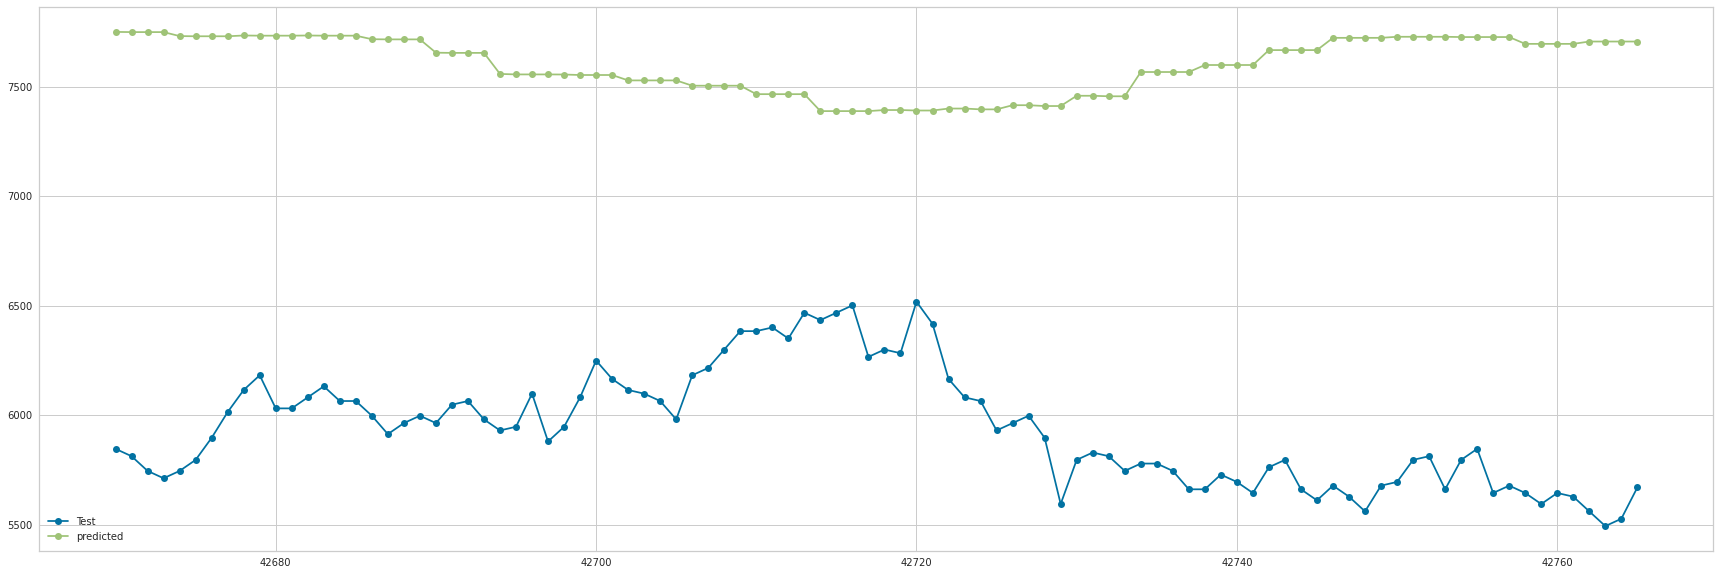

In [30]:
import matplotlib.pyplot as plt
# predict, real 비교 plot
def predict_graph(test,prediction) : 

    #plot
    plt.figure(figsize=(30,10))
    kws = dict(marker='o')
    plt.plot(test, label='Test', **kws)   
    plt.plot(prediction,label='predicted', **kws)
    plt.legend()
    return plt.show()

predict_graph(df_test_t['직전 15분 사용전력'],predictions_future['Label'])

feature import


In [17]:
#save the model
save_model(final_best, '/home/ykkim/pipeline_from_AutoML/pycaret/moorim_regression')


Transformation Pipeline and Model Successfully Saved


(ExponentialSmoothing(seasonal='mul', sp=4, trend='add'),
 '/home/ykkim/pipeline_from_AutoML/pycaret/Hansol_3hour_predict.pkl')

In [79]:
loaded_model = load_model('/home/ykkim/pipeline_from_AutoML/pycaret/moorim_regression')
print(loaded_model)

Transformation Pipeline and Model Successfully Loaded
ExponentialSmoothing(seasonal='mul', sp=4, trend='add')


In [80]:
loaded_model.predict()

2022-06-30 00:00    5933.659531
2022-06-30 00:15    5926.247400
2022-06-30 00:30    5935.219384
2022-06-30 00:45    5921.809389
2022-06-30 01:00    5933.493907
2022-06-30 01:15    5926.081982
2022-06-30 01:30    5935.053713
2022-06-30 01:45    5921.644092
2022-06-30 02:00    5933.328282
2022-06-30 02:15    5925.916563
2022-06-30 02:30    5934.888043
2022-06-30 02:45    5921.478794
Freq: 15T, dtype: float64

In [2]:
import pycaret   #pip install --pre pycaret
import sklearn
print(pycaret.__version__)
print(sklearn.__version__)

3.0.0
0.23.2
